In [1]:
import numpy as np
import pandas as pd
from glob import glob
from subprocess import check_output

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.metrics import r2_score

import pylab as plt
%matplotlib inline

/home/ishanu/.local/lib/python3.7/site-packages/statsmodels/compat/pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


## Get data

In [2]:
with open('../datasets//steps.dat', 'r') as handle:
    steps = handle.readline().strip().split()
    
ns = len(steps)

steps_c = [f'case{i}' for i in range(ns)]
steps_d = [f'death{i}' for i in range(ns)]
steps_ = steps_c + steps_d

In [4]:
glob('../datasets//data_????-??-??.csv')[0]

'../datasets/data_2020-12-06.csv'

In [5]:
data_fname = glob('../datasets//data_????-??-??.csv')[0]

# Get the two totals
last_date = data_fname.split('/')[-1][:-4].split('_')[-1]
print(f'last date = {last_date}')
steps_c = steps_c + [f'total_case']
steps_d = steps_d + [f'total_death']
steps_ = steps_c + steps_d

df = pd.read_csv(data_fname, dtype={'fips': str}).set_index('fips')
# tmp = df[[col for col in df.columns if col.startswith('case') or col.startswith('death')]]
# (tmp < 0).sum()

last date = 2020-12-06


In [6]:
df

,65yrs,minority,black,hispanic,population,perc_65yrs,perc_minority,perc_black,perc_hispanic,poverty,...,death28,death29,death30,death31,death32,death33,death34,death35,total_case,total_death
fips,,,,,,,,,,,,,,,,,,,,,
01001,8924,13262,11237,1671,55869,0.159731,0.237377,0.201131,0.029909,7587,...,0.0,3.0,0.0,0.0,6.0,3.0,3.0,0.0,3005,42
01003,46830,28036,19593,10534,223234,0.209780,0.125590,0.087769,0.047188,21069,...,2.0,2.0,2.0,12.0,1.0,0.0,14.0,40.0,9728,138
01005,4861,12552,11906,1117,24686,0.196913,0.508466,0.482298,0.045248,6788,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,19.0,1223,29
01007,3733,5203,4763,623,22394,0.166696,0.232339,0.212691,0.027820,4400,...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,21.0,1293,38
01009,10814,2414,978,5582,57826,0.187009,0.041746,0.016913,0.096531,7527,...,7.0,2.0,0.0,1.0,8.0,2.0,4.0,6.0,3299,46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56037,5489,2645,598,6772,42343,0.129632,0.062466,0.014123,0.159932,3540,...,0.0,0.0,0.0,2.0,0.0,2.0,0.0,4.0,2112,10
56039,3717,1179,172,3554,23464,0.158413,0.050247,0.007330,0.151466,1443,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1785,2
56041,3025,949,152,1871,20226,0.149560,0.046920,0.007515,0.092505,2010,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1198,5


In [7]:
df['urban_risk'] = df['perc_urban_pop'] * (df['risk_flu'] - df['risk_flu'].min())
covariates = [
    'population', 
    'perc_65yrs', 
    'perc_minority', 
    'perc_black', 
    'perc_hispanic', 
    'perc_poverty', 
    'perc_urban_pop',
    'income',
    'risk_flu',
    'urban_risk'
]

df_z = df[steps_].copy()
for c in covariates:
    mean, std = df[c].mean(), df[c].std()
    df_z[c] = (df[c] - mean) / std
df_z.head()

,case0,case1,case2,case3,case4,case5,case6,case7,case8,case9,...,population,perc_65yrs,perc_minority,perc_black,perc_hispanic,perc_poverty,perc_urban_pop,income,risk_flu,urban_risk
fips,,,,,,,,,,,,,,,,,,,,,
01001,12.0,7.0,6.0,11.0,11.0,16.0,45.0,48.0,60.0,48.0,...,-0.149053,-0.794106,0.512705,0.741329,-0.489703,-0.225017,0.535824,0.480936,1.006875,0.666999
01003,34.0,36.0,40.0,45.0,30.0,34.0,42.0,19.0,12.0,29.0,...,0.349320,0.257409,-0.180113,-0.042334,-0.365711,-0.883379,0.526204,0.353735,1.296454,0.817850
01005,3.0,7.0,8.0,16.0,9.0,14.0,24.0,27.0,47.0,41.0,...,-0.241908,-0.012923,2.192825,2.685016,-0.379632,2.589482,-0.291414,-1.333023,0.420657,-0.240836
01007,4.0,9.0,13.0,8.0,7.0,4.0,7.0,7.0,15.0,5.0,...,-0.248733,-0.647773,0.481481,0.821243,-0.504693,1.091708,-0.310652,-0.483902,0.436170,-0.249735
01009,12.0,3.0,9.0,12.0,6.0,5.0,2.0,3.0,13.0,11.0,...,-0.143225,-0.221003,-0.699751,-0.532156,-0.011632,-0.323771,-1.003223,-0.167862,0.617627,-0.724261


## Get GLM predictions

In [13]:
cov_prefix = 'perc_65yrs+perc_minority+perc_black+perc_hispanic+perc_poverty+income+'
cov = cov_prefix + 'perc_urban_pop'

In [14]:
df_z['pcy'] = df.case0/df.case0.sum()
steps_c[0]

'case0'

In [15]:
cur = steps_c[0]

Y='pcy'
#formula = f'{cur}~{cov}'
formula = f'{Y}~{cov}'

model = smf.glm(
    formula=formula,
    data=df_z,
    family=sm.families.Poisson(sm.families.links.log())
).fit()
print(f'{model.summary()}\n\n')

prd = model.predict()
cor = pd.DataFrame(
    data={'prd': prd, 'grd': df_z[cur].values}, 
    index=df.index).corr().loc['prd', 'grd']
#cors.append(cor)

df_z[cur + '_glm'] = model.predict()
 

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    pcy   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3086
Model Family:                 Poisson   Df Model:                            7
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -6.4292
Date:                Mon, 22 Feb 2021   Deviance:                       1.8988
Time:                        19:50:31   Pearson chi2:                     4.34
No. Iterations:                     8   Covariance Type:             nonrobust
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        -11.6883      5.431     -2.152      0.031     -22.334      -1.043
perc_65yrs         0.3695      1.174    

### Case 

In [16]:
dfs_case = []
cors = []
for i in range(len(steps_c)):
    cur = steps_c[i]
    formula = f'{cur}~{cov}'

    model = smf.glm(
        formula=formula,
        data=df_z,
        family=sm.families.Poisson(sm.families.links.log())
    ).fit()
    print(f'{model.summary()}\n\n')
    
    prd = model.predict()
    cor = pd.DataFrame(
        data={'prd': prd, 'grd': df_z[cur].values}, 
        index=df.index).corr().loc['prd', 'grd']
    cors.append(cor)
    
    df_z[cur + '_glm'] = model.predict()
    
    dfs_case.append(pd.read_html(model.summary().tables[1].as_html(), header=0, index_col=0)[0])

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  case0   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3086
Model Family:                 Poisson   Df Model:                            7
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.9551e+05
Date:                Mon, 22 Feb 2021   Deviance:                   5.8115e+05
Time:                        19:50:35   Pearson chi2:                 1.33e+06
No. Iterations:                     8   Covariance Type:             nonrobust
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.9432      0.010     96.076      0.000       0.924       0.962
perc_65yrs         0.3695      0.002    

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  case6   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3086
Model Family:                 Poisson   Df Model:                            7
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.3776e+05
Date:                Mon, 22 Feb 2021   Deviance:                   2.6624e+05
Time:                        19:50:36   Pearson chi2:                 7.46e+05
No. Iterations:                     7   Covariance Type:             nonrobust
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          2.1168      0.007    284.960      0.000       2.102       2.131
perc_65yrs         0.0145      0.004    

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 case12   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3086
Model Family:                 Poisson   Df Model:                            7
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.1983e+05
Date:                Mon, 22 Feb 2021   Deviance:                   4.2795e+05
Time:                        19:50:36   Pearson chi2:                 9.86e+05
No. Iterations:                     7   Covariance Type:             nonrobust
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          2.6005      0.006    448.885      0.000       2.589       2.612
perc_65yrs         0.0088      0.003    

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 case18   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3086
Model Family:                 Poisson   Df Model:                            7
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.3383e+05
Date:                Mon, 22 Feb 2021   Deviance:                   4.5295e+05
Time:                        19:50:37   Pearson chi2:                 7.20e+05
No. Iterations:                     7   Covariance Type:             nonrobust
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          3.4978      0.004    934.194      0.000       3.490       3.505
perc_65yrs        -0.0495      0.002    

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 case23   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3086
Model Family:                 Poisson   Df Model:                            7
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.2190e+05
Date:                Mon, 22 Feb 2021   Deviance:                   2.2947e+05
Time:                        19:50:38   Pearson chi2:                 3.29e+05
No. Iterations:                     6   Covariance Type:             nonrobust
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          3.3374      0.004    805.345      0.000       3.329       3.346
perc_65yrs        -0.2550      0.003    

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 case28   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3086
Model Family:                 Poisson   Df Model:                            7
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.8292e+05
Date:                Mon, 22 Feb 2021   Deviance:                   3.4922e+05
Time:                        19:50:38   Pearson chi2:                 5.05e+05
No. Iterations:                     6   Covariance Type:             nonrobust
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          3.9332      0.003   1270.975      0.000       3.927       3.939
perc_65yrs        -0.2109      0.002    

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 case34   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3086
Model Family:                 Poisson   Df Model:                            7
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -5.0079e+05
Date:                Mon, 22 Feb 2021   Deviance:                   9.8180e+05
Time:                        19:50:39   Pearson chi2:                 1.42e+06
No. Iterations:                     6   Covariance Type:             nonrobust
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          4.7716      0.002   2303.405      0.000       4.768       4.776
perc_65yrs        -0.1008      0.001    

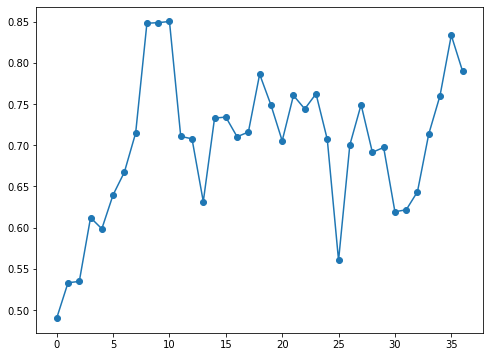

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(cors, marker='o')

### Death

In [9]:
dfs_death = []
cors = []
for i in range(len(steps_d)):
    cur = steps_d[i]
    formula = f'{cur}~{cov}'

    model = smf.glm(
        formula=formula,
        data=df_z,
        family=sm.families.Poisson(sm.families.links.log())
    ).fit()
    print(f'{model.summary()}\n\n')
    
    prd = model.predict()
    cor = pd.DataFrame(
        data={'prd': prd, 'grd': df_z[cur].values}, 
        index=df.index).corr().loc['prd', 'grd']
    cors.append(cor)
    
    df_z[cur + '_glm'] = model.predict()
    
    dfs_death.append(pd.read_html(model.summary().tables[1].as_html(), header=0, index_col=0)[0])

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 death0   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3085
Model Family:                 Poisson   Df Model:                            8
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -13019.
Date:                Mon, 22 Feb 2021   Deviance:                       23981.
Time:                        16:19:46   Pearson chi2:                 1.71e+05
No. Iterations:                    10   Covariance Type:             nonrobust
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -3.1803      0.065    -49.148      0.000      -3.307      -3.053
population         0.0923      0.002    

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 death6   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3085
Model Family:                 Poisson   Df Model:                            8
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -10033.
Date:                Mon, 22 Feb 2021   Deviance:                       17480.
Time:                        16:19:47   Pearson chi2:                 4.41e+04
No. Iterations:                     7   Covariance Type:             nonrobust
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.8858      0.033    -26.467      0.000      -0.951      -0.820
population         0.1295      0.002    

                 Generalized Linear Model Regression Results                  
Dep. Variable:                death12   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3085
Model Family:                 Poisson   Df Model:                            8
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -7425.6
Date:                Mon, 22 Feb 2021   Deviance:                       12657.
Time:                        16:19:47   Pearson chi2:                 3.22e+04
No. Iterations:                     8   Covariance Type:             nonrobust
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -1.2200      0.039    -30.957      0.000      -1.297      -1.143
population         0.0993      0.002    

                 Generalized Linear Model Regression Results                  
Dep. Variable:                death17   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3085
Model Family:                 Poisson   Df Model:                            8
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -7903.2
Date:                Mon, 22 Feb 2021   Deviance:                       12373.
Time:                        16:19:48   Pearson chi2:                 2.00e+04
No. Iterations:                     7   Covariance Type:             nonrobust
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.2710      0.024    -11.187      0.000      -0.318      -0.223
population         0.1200      0.002    

                 Generalized Linear Model Regression Results                  
Dep. Variable:                death22   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3085
Model Family:                 Poisson   Df Model:                            8
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -6104.2
Date:                Mon, 22 Feb 2021   Deviance:                       8872.3
Time:                        16:19:48   Pearson chi2:                 1.35e+04
No. Iterations:                     6   Covariance Type:             nonrobust
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.3673      0.026    -14.340      0.000      -0.417      -0.317
population         0.1238      0.002    

                 Generalized Linear Model Regression Results                  
Dep. Variable:                death27   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3085
Model Family:                 Poisson   Df Model:                            8
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -5653.7
Date:                Mon, 22 Feb 2021   Deviance:                       7783.3
Time:                        16:19:49   Pearson chi2:                 1.12e+04
No. Iterations:                     6   Covariance Type:             nonrobust
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.2231      0.024     -9.364      0.000      -0.270      -0.176
population         0.1197      0.003    

                 Generalized Linear Model Regression Results                  
Dep. Variable:                death34   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3085
Model Family:                 Poisson   Df Model:                            8
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8692.5
Date:                Mon, 22 Feb 2021   Deviance:                       11930.
Time:                        16:19:50   Pearson chi2:                 1.58e+04
No. Iterations:                     6   Covariance Type:             nonrobust
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.5377      0.016     32.821      0.000       0.506       0.570
population         0.1360      0.002    

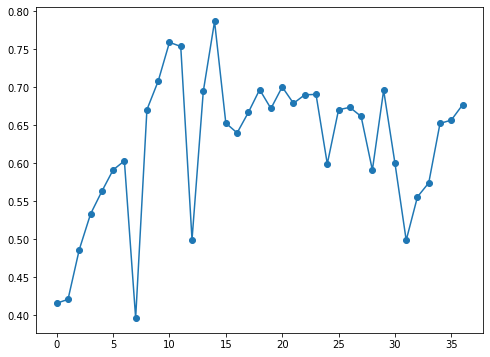

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(cors, marker='o')

In [ ]:
# cleanup and save
existing_csv = glob('../datasets//data_????-??-??_glm.csv')

if len(existing_csv) > 0:
    for csv in existing_csv:
        check_output(f'rm {csv}', shell=True)
        
df_z.to_csv(data_fname[:-4] + '_glm.csv', float_format='%.2f')

In [12]:
df_z

,case0,case1,case2,case3,case4,case5,case6,case7,case8,case9,...,death27_glm,death28_glm,death29_glm,death30_glm,death31_glm,death32_glm,death33_glm,death34_glm,death35_glm,total_death_glm
fips,,,,,,,,,,,,,,,,,,,,,
01001,12.0,7.0,6.0,11.0,11.0,16.0,45.0,48.0,60.0,48.0,...,1.325723,1.323760,1.685558,1.770392,2.393491,2.425326,3.246319,2.942134,4.303958,53.968159
01003,34.0,36.0,40.0,45.0,30.0,34.0,42.0,19.0,12.0,29.0,...,1.307517,1.614943,2.006954,1.958739,2.296776,2.678370,3.709330,3.642656,5.250512,50.330440
01005,3.0,7.0,8.0,16.0,9.0,14.0,24.0,27.0,47.0,41.0,...,0.864814,0.722388,0.760615,0.683023,1.177328,0.836413,1.052941,0.869184,1.219892,35.403868
01007,4.0,9.0,13.0,8.0,7.0,4.0,7.0,7.0,15.0,5.0,...,0.614546,0.532426,0.689892,0.760187,1.147686,0.981283,1.248868,1.089784,1.543919,16.665468
01009,12.0,3.0,9.0,12.0,6.0,5.0,2.0,3.0,13.0,11.0,...,0.266582,0.294399,0.395480,0.442837,0.578066,0.576089,0.714231,0.673205,0.895250,4.588990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56037,4.0,3.0,3.0,6.0,2.0,1.0,4.0,2.0,2.0,5.0,...,3.268540,3.064294,3.780804,4.391721,5.241772,6.367250,9.107392,8.466839,13.490512,164.602162
56039,36.0,17.0,9.0,33.0,2.0,1.0,2.0,0.0,0.0,0.0,...,0.877569,0.795507,0.897341,1.014346,1.414634,1.489189,1.949096,1.867977,2.915770,49.062584
56041,2.0,2.0,2.0,1.0,1.0,1.0,1.0,2.0,0.0,7.0,...,1.114747,1.117407,1.509819,1.771238,2.172982,2.452095,3.312708,3.103910,4.598375,34.536761


## Validation

In [16]:
cols = [col for col in df_z.columns if (col.startswith('case')) or (col.startswith('death'))]
(df_z[cols] < 0).sum().sum()

0

In [17]:
for i, s in enumerate(steps):
    print(f'{i}: {s}')

0: 2020-04-04
1: 2020-04-11
2: 2020-04-18
3: 2020-04-25
4: 2020-05-02
5: 2020-05-09
6: 2020-05-16
7: 2020-05-23
8: 2020-05-30
9: 2020-06-06
10: 2020-06-13
11: 2020-06-20
12: 2020-06-27
13: 2020-07-04
14: 2020-07-11
15: 2020-07-18
16: 2020-07-25
17: 2020-08-01
18: 2020-08-08
19: 2020-08-15
20: 2020-08-22
21: 2020-08-29
22: 2020-09-05
23: 2020-09-12
24: 2020-09-19
25: 2020-09-26
26: 2020-10-03
27: 2020-10-10
28: 2020-10-17
29: 2020-10-24
30: 2020-10-31
31: 2020-11-07
32: 2020-11-14
33: 2020-11-21
34: 2020-11-28
35: 2020-12-05
